In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [90]:
data = pd.read_csv("/Users/jonahwilliams/Documents/Kaggle/Forest/train.csv")
data = data.drop("Id", axis=1)
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


So here we have the forrest cover data - it looks like we have several real-valued dimensions, as well as several binary dimensions.  With a mix of data types, a good first stab is a random forrest.  

I'll go ahead and create a validation set for comparison of the different model techniques

In [93]:
X = data.values[:, 0:-1]
y = data.values[:, -1]

In [66]:
X

array([[2596,   51,    3, ...,    0,    0,    0],
       [2590,   56,    2, ...,    0,    0,    0],
       [2804,  139,    9, ...,    0,    0,    0],
       ..., 
       [2492,  134,   25, ...,    0,    0,    0],
       [2487,  167,   28, ...,    0,    0,    0],
       [2475,  197,   34, ...,    0,    0,    0]])

In [67]:
y

array([5, 5, 2, ..., 3, 3, 3])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(verbose=True)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=True)

In [8]:
rfc.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.85449735449735453

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


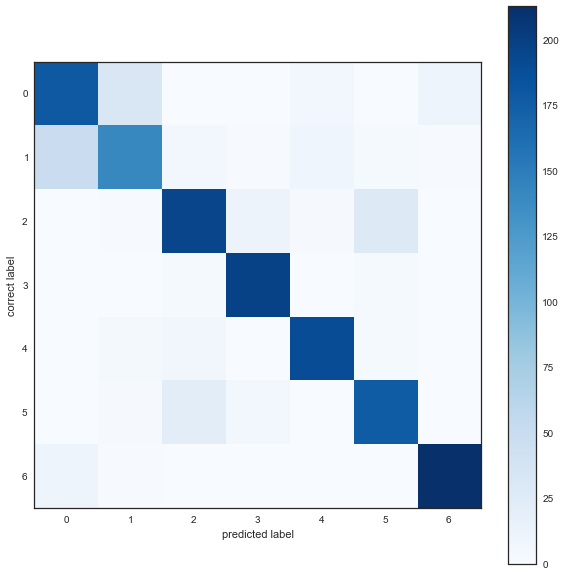

In [9]:
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.set_style("white")
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.xlabel("predicted label")
plt.ylabel("correct label")
plt.colorbar()
plt.show()

In [10]:
cm

array([[179,  32,   0,   0,   6,   0,  10],
       [ 49, 141,   6,   1,   9,   3,   1],
       [  0,   1, 195,  12,   2,  27,   0],
       [  0,   0,   3, 198,   0,   3,   0],
       [  0,   4,   7,   0, 189,   3,   0],
       [  0,   2,  22,   6,   0, 177,   0],
       [ 10,   1,   0,   0,   0,   0, 213]])

So out of the box, the random forrest gives us fairly good results with default settings - an overall accuracy of 0.83.  Lets see if we can take advantage of some of the nice SVM properties with different kernels.  We have both continuous and binary data - if we can use a polynomial kernel with the binary data (computing logical conjunctions) and an rbf kernel with the continuous data, all optimized with a GP, maybe we can improve our results evern further


Polynomial Kernel

$$K(x, y) = (x \cdot y^{T} + c)^d$$

Therefore we'll need to choose values of c and values of $d \geq 1$

RBF Kernel

$$K(x, y) = exp(\frac{||x - y ||^2}{2\sigma^2}) $$

Therefore we'll need to choose a value of sigma for each real valued dimension -  though at first we'll use one value.

In order to combine the kernels we will precompute the gram matrix for python

In [39]:
def compute_gram(X, gamma=0.1, d=3):
    gram_real = np.zeros((len(X), len(X)), dtype=np.float64)
    gram_binary = np.zeros((len(X), len(X)), dtype=np.int64)
    
    # Compute Kernel for real valued features
    gram_real = (np.sum(X[:,0:10]**2, 1).reshape(-1, 1) + np.sum(X[:,0:10]**2, 1)
                 -2 * np.dot(X[:,0:10], X[:,0:10].T))
    gram_real = np.exp(gamma * gram_real)
    
    # Compute Kernel for binary features
    gram_binary = (np.dot(X[:,10:], X[:,10:].T))**d
    return gram_real * gram_binary

In [33]:
# we should normalize the real features for numerical stability
X_train_norm = X_train.copy()
X_train_norm = X_train_norm.astype(float)
X_train_norm[:,0:10] = (X_train_norm[:, 0:10] - np.mean(X_train[:, 0:10], axis=0)) / np.std(X_train[:,0:10], 0)

In [34]:
gram_matrix = compute_gram(X_train_norm, 1, 2)

In [35]:
gram_matrix

array([[  4.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   4.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   4.30892139e+03,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.00000000e+00, ...,
          8.86156321e+01,   0.00000000e+00,   3.80965787e+01],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   8.86156321e+01, ...,
          4.00000000e+00,   0.00000000e+00,   1.06657339e+01],
       [  0.00000000e+00,   4.30892139e+03,   0.00000000e+00, ...,
          0.00000000e+00,   4.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   3.80965787e+01, ...,
          1.06657339e+01,   0.00000000e+00,   4.00000000e+00]])

In [36]:
from sklearn.svm import SVC
clf = SVC(kernel="precomputed", verbose=True)

In [37]:
clf.fit(gram_matrix, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=True)

In [38]:
clf.score(gram_matrix, y_train)

0.15174897119341563

In [24]:
# Not great!

In [46]:
best_score = 0
best_params = [0, 0, 0]
for i in range(10):
    c = np.random.randint(-20, 20)
    g = np.random.randint(-20, 0)
    d = np.random.randint(1, 5)

    gram_matrix = compute_gram(X_train_norm, gamma=2**g, d=d)
    clf = SVC(kernel="precomputed", C=2**c)
    clf.fit(gram_matrix, y_train)
    score = clf.score(gram_matrix, y_train)
    print "current score: " + str(score) + ", best score: " + str(best_score)
    if score > best_score:
        best_score = score
        best_params = [c, g, d]


current score: 0.524323927102, best score: 0
current score: 0.155349794239, best score: 0.524323927102
current score: 0.459729570841, best score: 0.524323927102
current score: 0.4699441505, best score: 0.524323927102
current score: 0.580393885949, best score: 0.524323927102
current score: 0.143812463257, best score: 0.580393885949
current score: 0.595238095238, best score: 0.580393885949
current score: 0.41879776602, best score: 0.595238095238
current score: 0.472075249853, best score: 0.595238095238
current score: 0.597810111699, best score: 0.595238095238


In [47]:
best_params

[0, -19, 3]

Well I had some slight improvement - but really its still pretty shit

In [58]:
clf = SVC(kernel="rbf")

In [72]:
X_test_norm = X_test.copy()
X_test_norm[:, 0:10] = (X_test_norm[:, 0:10] - np.mean(X_train[:, 0:10], axis=0)) / np.std(X_train[:,0:10], 0)
X_train_norm = X_train.copy()
X_train_norm = X_train_norm.astype(float)
X_train_norm[:,0:10] = (X_train_norm[:, 0:10] - np.mean(X_train[:, 0:10], axis=0)) / np.std(X_train[:,0:10], 0)

In [73]:
clf.fit(X_train_norm, y_train)
clf.score(X_test_norm, y_test)

0.61904761904761907

How about total overkill?

In [91]:
from __future__ import absolute_import
from __future__ import print_function

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils, generic_utils
import keras.optimizers

In [185]:
from sklearn.cross_validation import StratifiedShuffleSplit
X = data.values[:, 0:-1]
y = data.values[:, -1]
# convert 0 and 1 to -1 and 1
X[:,10:] *= 2
X[:,10:] -= 1


sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.15, random_state=0)


for train_index, test_index in sss:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train[:,0:10] = (X_train[:,0:10] - np.mean(X_train[:,0:10], 0)) / np.std(X_train[:,0:10], 0)
X_test[:,0:10] = (X_test[:,0:10] - np.mean(X_train[:,0:10], 0)) / np.std(X_train[:,0:10], 0)

TRAIN: [ 7044 12136  7130 ...,  4171  3360  1039] TEST: [12841 13526  1512 ...,  4215 13122 12759]


In [186]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train).astype(np.int32)
y_train = np_utils.to_categorical(y_train)

nb_classes = y_train.shape[1]
dims = X_train.shape[1]


model = Sequential()
model.add(Dense(dims, 128, init='uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(128, 128, init='uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(128, nb_classes, init='uniform'))
model.add(Activation('softmax'))

sgd = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

print("Training model...")

model.fit(X_train, y_train, nb_epoch=30, batch_size=16, validation_split=0)

Training model...
Epoch 0
12852/12852 [==============================] - 1s - loss: 29.5417     
Epoch 1
12852/12852 [==============================] - 2s - loss: 29.5584     
Epoch 2
12852/12852 [==============================] - 2s - loss: 29.5690     
Epoch 3
12852/12852 [==============================] - 2s - loss: 29.5957     
Epoch 4
12852/12852 [==============================] - 2s - loss: 29.5903     
Epoch 5
12852/12852 [==============================] - 2s - loss: 29.6604     
Epoch 6
12852/12852 [==============================] - 2s - loss: 29.6092     
Epoch 7
12852/12852 [==============================] - 2s - loss: 29.5742     
Epoch 8
12852/12852 [==============================] - 3s - loss: 29.6821     
Epoch 9
12852/12852 [==============================] - 3s - loss: 29.6820     
Epoch 10
12852/12852 [==============================] - 3s - loss: 29.6068     
Epoch 11
12852/12852 [==============================] - 3s - loss: 29.6418     
Epoch 12
12852/12852 [==========

In [189]:
y_pred = model.predict_classes(X_test)

2268/2268 [==============================] - 0s     


In [190]:
sum(y_test - 1 != y_pred) / (len(y_test) * 1.0)

0.8571428571428571

I maxedout at 0.85 error rate, very simil